In [1]:
import os
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

mpl.rcParams['text.usetex'] = True

sns.set_theme(style="darkgrid")
sns.set(rc={"figure.figsize": (3.14, 3.14 / 1.6),
            "legend.fontsize": 12,
            "legend.title_fontsize": 14},
        font_scale=1.5)

log_yscale = False

In [2]:
DATA_LOCATION = Path("data")
OUTPUT_IMAGES_LOCATION = Path("output_images") / "attack_effectiveness"
FILENAME = "attack-effectiveness-"

if not OUTPUT_IMAGES_LOCATION.exists():
    OUTPUT_IMAGES_LOCATION.mkdir(parents=True)

def get_filename(name):
    return DATA_LOCATION / f"{FILENAME}{name}.csv"

get_filename("xcit")

PosixPath('data/attack-effectiveness-xcit.csv')

In [3]:
def relative_diff(x1, x2):
    return np.abs(x2 - x1) / x2

In [4]:
pd.read_csv(get_filename("xcit"))[["adv_loss", "attack_steps", "epoch", "seed", "robust_top1"]].head()

,adv_loss,attack_steps,epoch,seed,robust_top1
0,8.971067,1,0,0,0.0
1,9.481953,2,0,0,0.0
2,9.857929,5,0,0,0.0
3,9.999073,10,0,0,0.0
4,10.102695,200,0,0,0.0


In [5]:
def process_df(model_name):
    filename = get_filename(model_name)
    raw_df = pd.read_csv(filename)
    raw_df["epoch"] = raw_df["epoch"] + 1
    raw_df = raw_df[raw_df["epoch"] != 1]
    processed_df = (
        raw_df[["adv_loss", "attack_steps", "epoch", "seed", "robust_top1"]]
            .pivot(["epoch", "seed"], columns='attack_steps', values='adv_loss')
    )
    return processed_df

df = process_df("xcit")
df.head()

attack_steps       1         2         5         10        200
epoch seed                                                    
10    0       3.731684  3.777879  3.802710  3.811381  3.821058
      1       3.732345  3.777894  3.802700  3.811361  3.821043
      2       3.732348  3.777875  3.802695  3.811375  3.821025
20    0       3.416565  3.467899  3.495501  3.505017  3.515385
      1       3.417367  3.467891  3.495504  3.505006  3.515369

In [6]:
def compute_relative_differences(df, attack_steps=(1, 2, 5, 10), wrt=200):
    rel_diffs_df = pd.DataFrame(index=df.index)
    for s1 in attack_steps:
        rel_diffs_df[f"{s1}"] = relative_diff(df[s1], df[wrt]) * 100
    return rel_diffs_df
                 

compute_relative_differences(df).head()

1         2         5        10
epoch seed                                        
10    0     2.338975  1.130034  0.480193  0.253253
      1     2.321301  1.129234  0.480058  0.253379
      2     2.320751  1.129258  0.479698  0.252537
20    0     2.811084  1.350820  0.565638  0.294935
      1     2.787834  1.350596  0.565084  0.294787

In [7]:
def compute_attack_effectiveness(model_name):
    df = process_df(model_name)
    relative_diffs_df = compute_relative_differences(df)
    return relative_diffs_df

xcit_rel_diffs = compute_attack_effectiveness("xcit")
xcit_rel_diffs["Model"] = "XCiT-S12"

xcit_original_rel_diffs = compute_attack_effectiveness("xcit-original")
xcit_original_rel_diffs["Model"] = "XCiT-S12$^*$"

resnet_rel_diffs = compute_attack_effectiveness("resnet")
resnet_rel_diffs["Model"] = "ResNet-50"

convnext_rel_diffs = compute_attack_effectiveness("convnext")
convnext_rel_diffs["Model"] = "ConvNeXt-T"

In [8]:
overall_df = pd.concat([resnet_rel_diffs, xcit_rel_diffs, xcit_original_rel_diffs, convnext_rel_diffs]).reset_index()
overall_df.head()

,epoch,seed,1,2,5,10,Model
0,10,0,3.009361,1.748645,0.895391,0.488780,ResNet-50
1,10,1,2.856323,1.747810,0.893685,0.487631,ResNet-50
2,10,2,2.856009,1.748044,0.894063,0.487940,ResNet-50
3,20,0,3.653088,2.142963,1.086315,0.589255,ResNet-50
4,20,1,3.541349,2.141868,1.086284,0.589256,ResNet-50


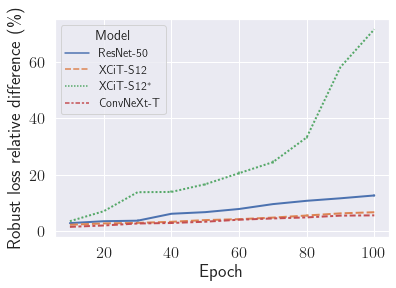

In [9]:
sns.lineplot(x="epoch", y="1", hue="Model", data=overall_df, err_style="bars", style="Model", linewidth=2)
plt.ylabel("Robust loss relative difference (\%)")
plt.xlabel("Epoch")
if log_yscale:
    plt.yscale("log")
plt.savefig(OUTPUT_IMAGES_LOCATION / "epoch_vs_pgd-1.pdf", bbox_inches="tight")

In [10]:
overall_df[overall_df["epoch"] == 100].drop("epoch", axis=1)

,seed,1,2,5,10,Model
27,0,12.745666,8.772657,4.672607,2.493608,ResNet-50
28,1,12.681530,8.777600,4.684062,2.499995,ResNet-50
29,2,12.673089,8.771105,4.675606,2.492102,ResNet-50
57,0,6.793415,3.415389,1.448147,0.786144,XCiT-S12
58,1,6.744913,3.415490,1.448465,0.781900,XCiT-S12
59,2,6.742237,3.411988,1.443786,0.783103,XCiT-S12
87,0,71.564987,67.221220,58.608668,40.550739,XCiT-S12$^*$
88,1,71.476012,67.276747,58.569044,40.532622,XCiT-S12$^*$
89,2,71.499635,67.270929,58.602913,40.552495,XCiT-S12$^*$
117,0,5.653856,2.609034,0.932285,0.440643,ConvNeXt-T


In [11]:
last_epoch_df = overall_df.melt(id_vars=["Model", "seed", "epoch"], var_name="steps", value_name="relative_diff")
last_epoch_df.head()

,Model,seed,epoch,steps,relative_diff
0,ResNet-50,0,10,1,3.009361
1,ResNet-50,1,10,1,2.856323
2,ResNet-50,2,10,1,2.856009
3,ResNet-50,0,20,1,3.653088
4,ResNet-50,1,20,1,3.541349


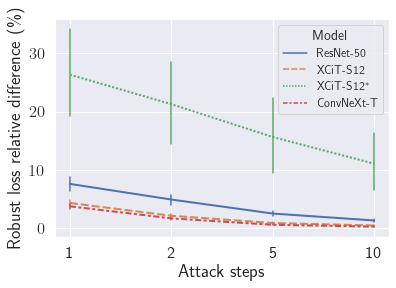

In [12]:
sns.lineplot(x="steps", y="relative_diff", hue="Model", data=last_epoch_df, err_style="bars", style="Model", linewidth=2)
plt.xlabel("Attack steps")
plt.ylabel("Robust loss relative difference (\%)")
if log_yscale:
    plt.yscale("log")
plt.savefig(OUTPUT_IMAGES_LOCATION / "steps.pdf", bbox_inches="tight")

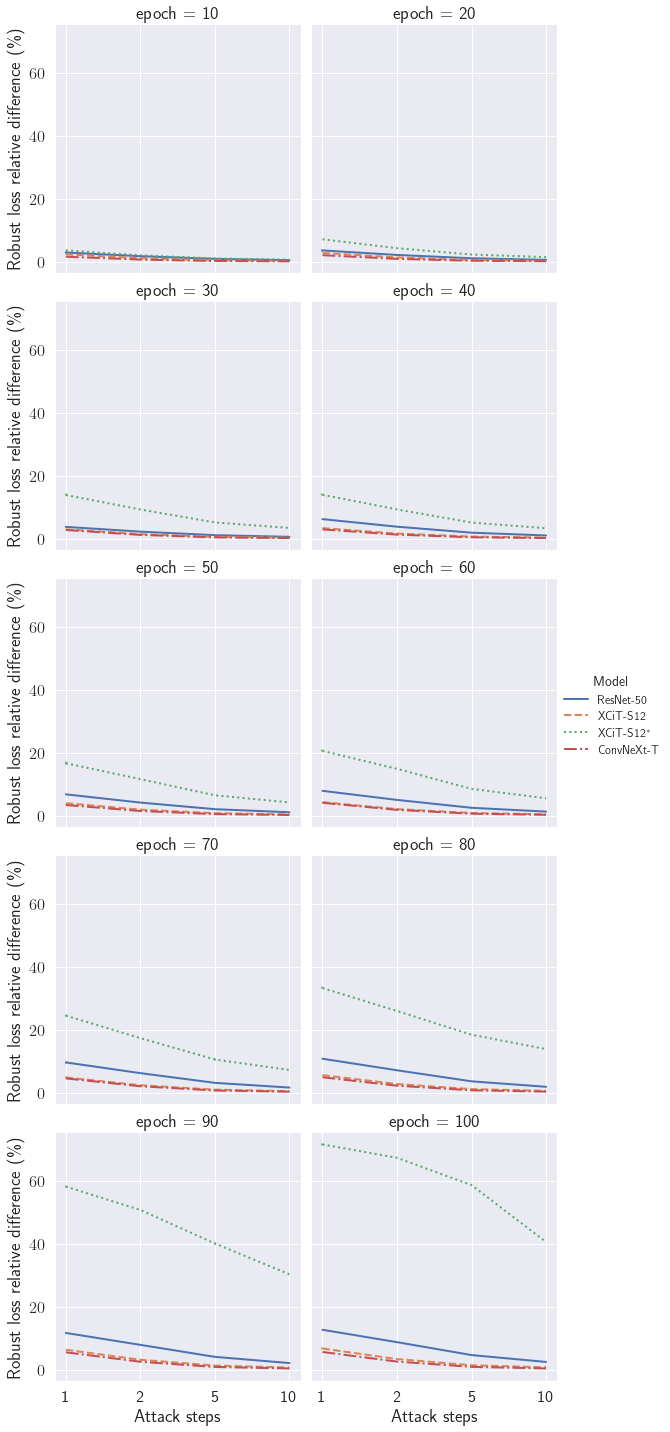

In [13]:
g = sns.FacetGrid(
    last_epoch_df,
    col="epoch",
    hue="Model",
    col_wrap=2,
    height=4,
    # sharey=False,
    hue_kws={"ls": ["solid", "dashed", "dotted", "dashdot"]}
)
g.map(sns.lineplot, "steps", "relative_diff", err_style="bars", linewidth=2)
g.add_legend()
g.set_axis_labels(x_var="Attack steps", y_var="Robust loss relative difference (\%)")
if log_yscale:
    plt.yscale("log")
plt.savefig(OUTPUT_IMAGES_LOCATION / "steps_unaggregated.pdf", bbox_inches="tight")

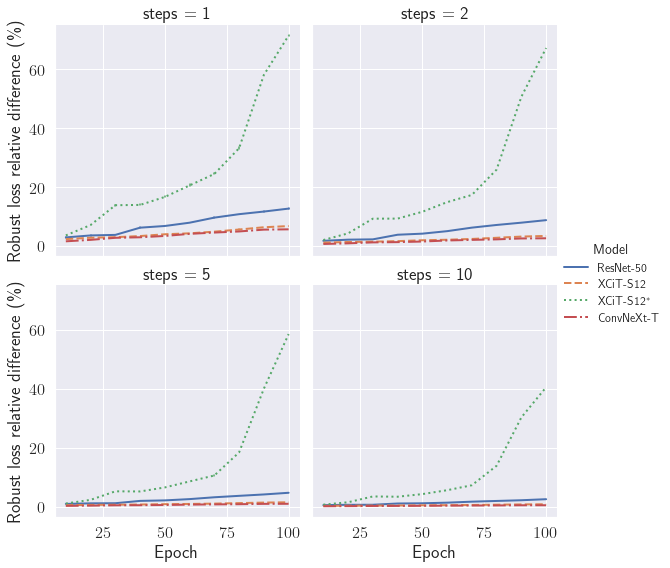

In [14]:
g = sns.FacetGrid(
    last_epoch_df,
    col="steps",
    hue="Model",
    height=4,
    col_wrap=2,
    # sharey=False,
    hue_kws={"ls": ["solid", "dashed", "dotted", "dashdot"]}
)
g.map(sns.lineplot, "epoch", "relative_diff", err_style="bars", linewidth=2)
g.set_axis_labels(x_var="Epoch", y_var="Robust loss relative difference (\%)")
g.add_legend()
if log_yscale:
    plt.yscale("log")
plt.savefig(OUTPUT_IMAGES_LOCATION / "steps_vs_relative_difference.pdf", bbox_inches="tight")

In [15]:
def process_df_top1(model_name):
    filename = get_filename(model_name)
    raw_df = pd.read_csv(filename)
    raw_df["epoch"] = raw_df["epoch"] + 1
    raw_df = raw_df[raw_df["epoch"] != 1]
    processed_df = (
        raw_df[["adv_loss", "attack_steps", "epoch", "seed", "robust_top1"]]
            .pivot(["epoch", "seed"], columns='attack_steps', values='robust_top1')
    )
    return processed_df

<AxesSubplot:xlabel='epoch', ylabel='200'>

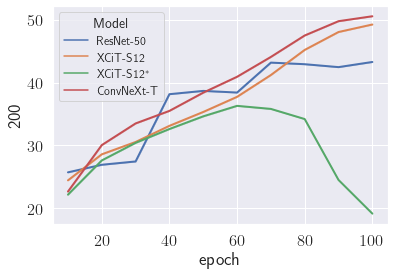

In [16]:
xcit_losses = process_df_top1("xcit")
xcit_losses["Model"] = "XCiT-S12"

xcit_original_losses = process_df_top1("xcit-original")
xcit_original_losses["Model"] = "XCiT-S12$^*$"

resnet_losses = process_df_top1("resnet")
resnet_losses["Model"] = "ResNet-50"

convnext_losses = process_df_top1("convnext")
convnext_losses["Model"] = "ConvNeXt-T"

losses_df = pd.concat([resnet_losses, xcit_losses, xcit_original_losses, convnext_losses]).reset_index()
sns.lineplot(x="epoch", y=200, data=losses_df, hue="Model", linewidth=2)